# Load a pretrained model and use it as a metric

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import PerceptNet
from paramperceptnet.configs import param_config

## Load a set of pretrained weights

Currently, the weights are stored in W&B (they will be in HF at some point), so we have to download them before putting them into our model.
The good part is that the configuration is stored along the weights, so we don't need to load them separatelly.

In [7]:
model_name = "ppnet-fully-trained"

In [8]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [9]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
state = variables["state"]
params = variables["params"]

## Instantiate the model

In [10]:
model = PerceptNet(config)

See that we don't need to initialize any weights now because we have loaded them from a checkpoint.

## Load an image and generate a modified version of it

In [11]:
import requests
from PIL import Image
from io import BytesIO

# Replace with your image URL
img_url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01498041_stingray.JPEG?raw=true"

# Fetch the image
response = requests.get(img_url, stream=True)
response.raw.decode_content = True

# Open the image using PIL
img_ = Image.open(BytesIO(response.content))

We are going to create a distorted version of the image by adding gaussian noise:

(375, 500, 3) 0.0 1.0
(375, 500, 3) 0.0 1.0


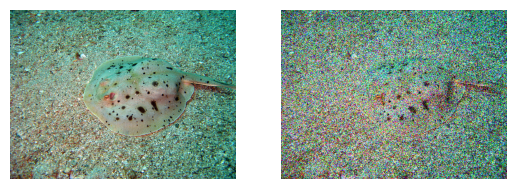

In [12]:
import matplotlib.pyplot as plt
img = jnp.array(img_)/255.0
img_dist = img + 0.4*random.normal(random.PRNGKey(42), img.shape)
img_dist = jnp.clip(img_dist, a_min=0., a_max=1.)
print(img.shape, img.min(), img.max())
print(img_dist.shape, img_dist.min(), img_dist.max())
fig, axes = plt.subplots(1,2)
for im, ax in zip((img, img_dist), axes.ravel()):
    ax.imshow(im)
    ax.axis("off")
plt.show()

And now we can use our model as a metric by obtaining the projection of both images and then calculating their L2 distance:

In [13]:
def l2_dist(a, b):
    return ((a-b)**2).mean()**(1/2)

In [14]:
pred = model.apply({"params": params, **state}, img[None,...], train=False)
pred_dist = model.apply({"params": params, **state}, img_dist[None,...], train=False)
dist = l2_dist(pred, pred_dist)
dist, l2_dist(img, img_dist)

(Array(0.09892901, dtype=float32), Array(0.31453824, dtype=float32))